In [8]:
from skimage import io, img_as_ubyte, color
from matplotlib import pyplot as plt

In [9]:
import numpy as np

In [10]:
from tqdm.notebook import tqdm

In [11]:
class RegionDSU:
    class PixelInfo:
        def __init__(self, intensity, parent, set_size):
            self.intensity_sum = intensity
            self.parent = parent
            self.set_size = set_size
            
        def _unchecked_merge(self, pixel_info):
            self.intensity_sum += pixel_info.intensity_sum
            self.set_size += pixel_info.set_size
            pixel_info.parent = self.parent
            
        def merge(self, pixel_info):
            if self.set_size < pixel_info.set_size:
                pixel_info._unchecked_merge(self)
            else:
                self._unchecked_merge(pixel_info)
    
    def __init__(self, flat_image):
        if flat_image.ndim != 1:
            raise "Please use flat image"
        self.image_size = flat_image.size
        self.pixels = [self.PixelInfo(int(flat_image[i]), i, 1) for i in range(self.image_size)]
        
    def find_root(self, pixel_idx):
        start_idx = pixel_idx
        while self.pixels[pixel_idx].parent != pixel_idx:
            pixel_idx = self.pixels[pixel_idx].parent
        self._compress_paths(start_idx, pixel_idx)
        return pixel_idx
    
    def _compress_paths(self, pixel_idx, root_idx):
        while self.pixels[pixel_idx].parent != root_idx:
            pixel_idx = self.pixels[pixel_idx].parent
            self.pixels[pixel_idx].parent = root_idx
        
    def merge(self, first_root, second_root):
        self.pixels[first_root].merge(self.pixels[second_root])
        
    def get_class_avg(self, class_root_idx):
        root_pixel = self.pixels[class_root_idx]
        return root_pixel.intensity_sum / root_pixel.set_size
    
    def get_region_roots(self):
        roots = []
        for i in range(self.image_size):
            if self.pixels[i].parent == i:
                roots.append(i)
        return roots
    
    def get_regions(self, roots=None):
        if roots is None:
            roots = self.get_region_roots()
        regions = {root: [] for root in roots}
        for i in tqdm(range(self.image_size)):
            root = self.find_root(self.pixels[i].parent)
            if root in roots:
                regions[root].append(i)
        return regions

In [12]:
dsu = RegionDSU(np.array([1, 2, 3, 4]))

In [13]:
dsu.get_region_roots()

[0, 1, 2, 3]

In [14]:
dsu.merge(1, 2)
dsu.get_region_roots()

[0, 1, 3]

In [15]:
dsu.get_regions()

{0: [0], 1: [1, 2], 3: [3]}

In [16]:
dsu.merge(0, 3)
dsu.get_region_roots()

[0, 1]

In [17]:
dsu.get_regions()

{0: [0, 3], 1: [1, 2]}

In [18]:
dsu.merge(0, 1)
dsu.get_region_roots()

[0]

In [19]:
dsu.get_regions()

{0: [0, 1, 2, 3]}

In [20]:
dsu.get_class_avg(0)

2.5

In [61]:
def region_growing(image, dsu, threshold=5, num_iter=1):
    img_shape = image.shape
    def flat_idx(i, j):
        return i * img_shape[1] + j
    def init_left():
        for i in range(1, image.shape[1]):
            cur_idx = flat_idx(i, 0)
            cur_root_idx = dsu.find_root(cur_idx)
            
            top_idx = flat_idx(i - 1, 0)
            top_root_idx = dsu.find_root(top_idx)
            top_avg = dsu.get_class_avg(top_root_idx)
            top_diff = np.abs(image[i][0] - top_avg)
            
            if top_diff <= threshold:
                dsu.merge(cur_root_idx, top_idx)
        
    def init_top():
        for j in range(1, image.shape[1]):
            cur_idx = flat_idx(0, j)
            cur_root_idx = dsu.find_root(cur_idx)
            
            left_idx = flat_idx(0, j - 1)
            left_root_idx = dsu.find_root(left_idx)
            left_avg = dsu.get_class_avg(left_root_idx)
            left_diff = np.abs(image[0][j] - left_avg)
            
            if left_diff <= threshold:
                dsu.merge(cur_root_idx, left_root_idx)

    init_left()
    init_top()
    for iter_idx in tqdm(range(num_iter)):            
        for i in range(1, image.shape[0]):
            for j in range(1, image.shape[1]):
                cur_idx = flat_idx(i, j)
                cur_root_idx = dsu.find_root(cur_idx)

                top_idx = flat_idx(i - 1, j)
                top_root_idx = dsu.find_root(top_idx)
                top_avg = dsu.get_class_avg(top_root_idx)
                top_diff = np.abs(image[i][j] - top_avg)

                left_idx = flat_idx(i, j - 1)
                left_root_idx = dsu.find_root(left_idx)
                left_avg = dsu.get_class_avg(left_root_idx)
                left_diff = np.abs(image[i][j] - left_avg)

                if top_diff <= threshold and left_diff <= threshold:
                    if np.abs(top_avg - left_avg) <= threshold:
                        dsu.merge(top_root_idx, left_root_idx)
                    else:
                        root_idx = [top_root_idx, left_root_idx]
                        dsu.merge(cur_root_idx, root_idx[np.argmin([top_diff, left_diff])])
                elif top_diff <= threshold:
                    dsu.merge(cur_root_idx, top_root_idx)
                elif left_diff <= threshold:
                    dsu.merge(cur_root_idx, left_root_idx)

In [85]:
from IPython.display import clear_output

plt.figure(figsize=(12,6))

def copy_region(image, flat_indices):
    flat_image = image.ravel()
    region = np.zeros(image.size, dtype=np.int32)
    for idx in flat_indices:
        region[idx] = flat_image[idx]
    return region.reshape(image.shape)

def mask_region(image, flat_indices):
    image_copy = image.ravel().copy()
    for idx in flat_indices:
        image_copy[idx] = 255
    return image_copy.reshape(image.shape)

def show_region(image, region):
    plt.figure(figsize=(18,6))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap=plt.cm.gray, vmin=0, vmax=255)
    plt.subplot(1, 3, 2)
    plt.imshow(copy_region(image, region), cmap=plt.cm.gray, vmin=0, vmax=255)
    plt.subplot(1, 3, 3)
    plt.imshow(mask_region(image, region), cmap=plt.cm.gray, vmin=0, vmax=255)
    plt.show()
        
def segment(image, threshold=5):
    dsu = RegionDSU(image.ravel())
    region_growing(image, dsu, threshold=threshold)
    roots = np.array(dsu.get_region_roots())
    regions = dsu.get_regions()    
    return (dsu, regions)

<Figure size 864x432 with 0 Axes>

In [63]:
# ! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip  # Linux
# ! curl https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=1 -L --output data.zip  # Mac
# ! unzip -q data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0^C
replace BBBC018_v1_images-fixed/test/00733-actin.DIB.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [64]:
segmentation_img = img_as_ubyte(color.rgb2gray(io.imread('BBBC018_v1_images-fixed/test/00733-actin.DIB.bmp')))

In [99]:
(dsu, regions) = segment(segmentation_img, 15)

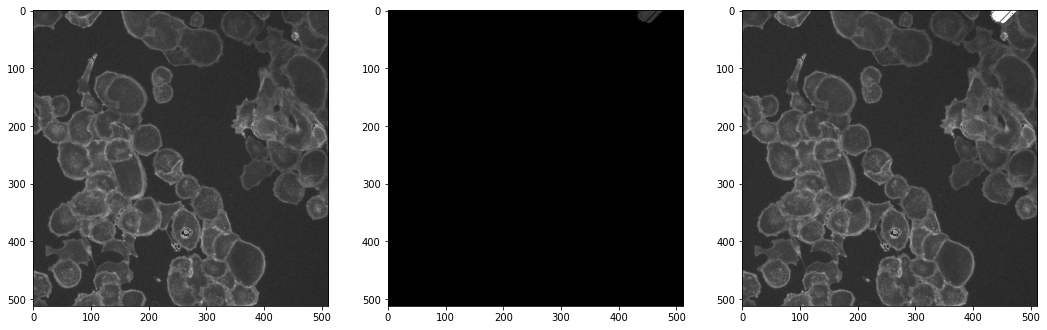

In [119]:
show_region(segmentation_img, regions[dsu.find_root(3000)])

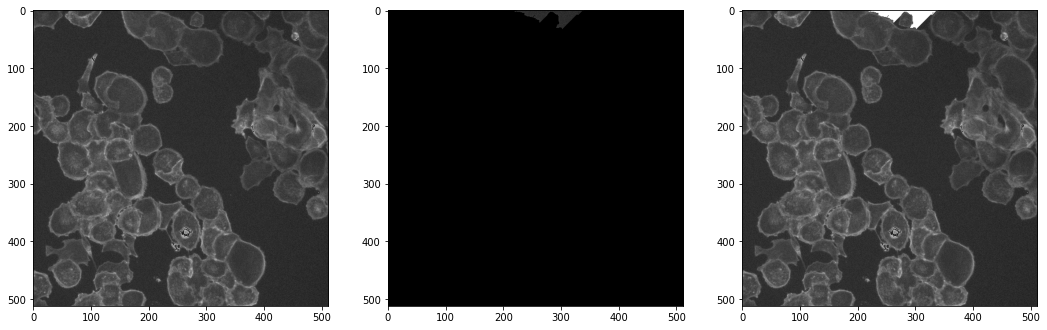

In [122]:
show_region(segmentation_img, regions[dsu.find_root(300)])

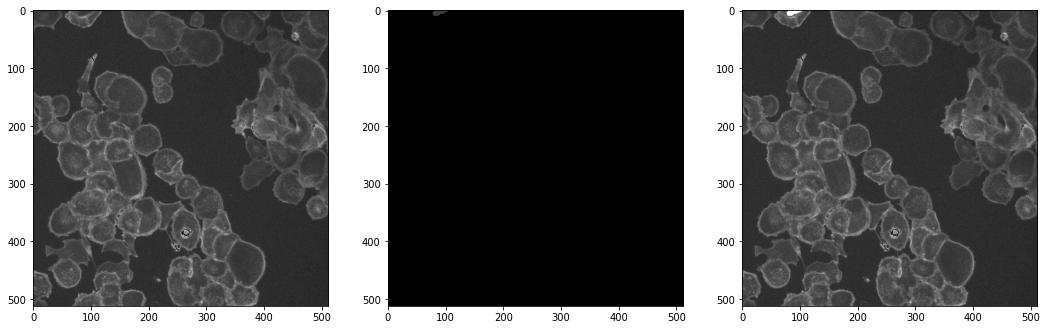

In [123]:
show_region(segmentation_img, regions[dsu.find_root(100)])

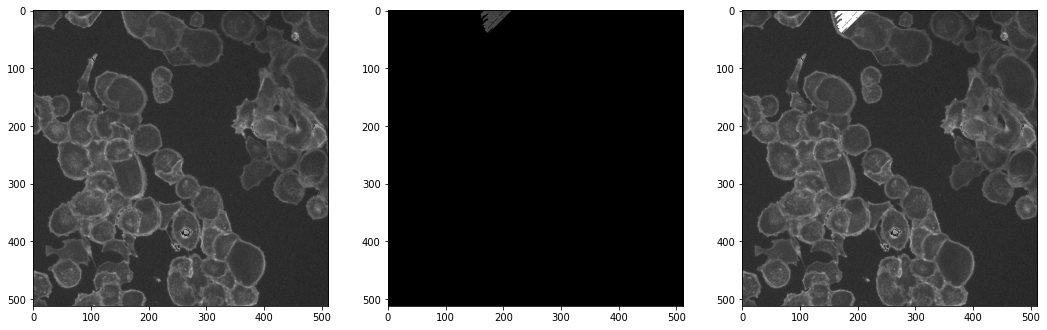

In [126]:
show_region(segmentation_img, regions[dsu.find_root(9900)])

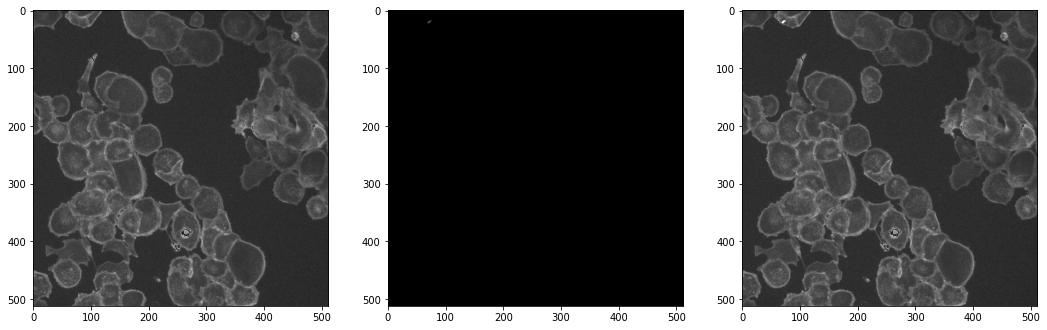

In [129]:
show_region(segmentation_img, regions[dsu.find_root(9800)])

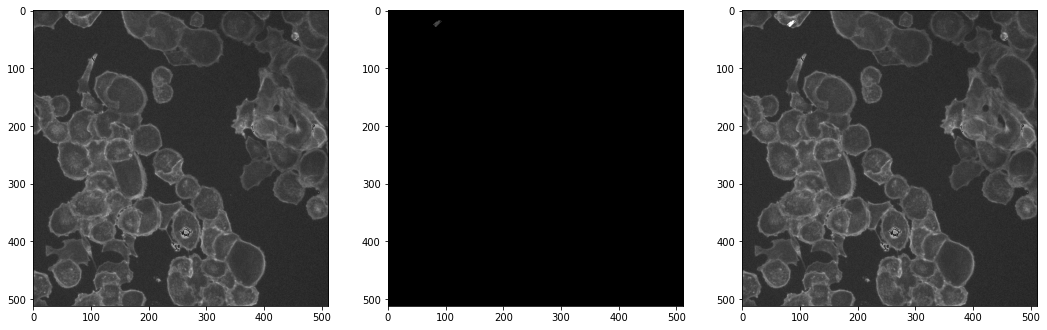

In [130]:
show_region(segmentation_img, regions[dsu.find_root(9820)])

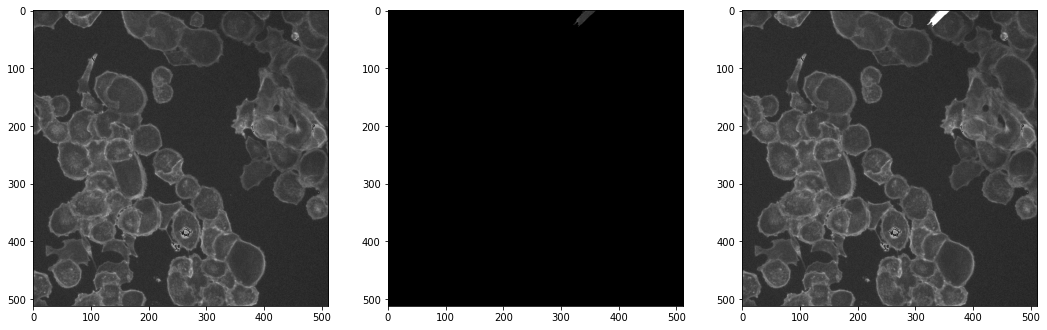

In [136]:
show_region(segmentation_img, regions[dsu.find_root(7500)])